In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

## Minimum Variance Portfolio Backtest.

In [2]:
from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [3]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 225
ESTIMATION_WINDOW = 365

ESTIMATOR = CovEstimators.PRETRAINED.value(name="irl")

In [4]:
trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=0,
)

preprocessor, runner = initialize(
    dataset=DATASET,
    with_causal_window=False,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [5]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 283/283 [00:37<00:00,  7.53it/s]


StrategyStatistics:
* final_nav = 12.997005
* geom_avg_total_r = 0.144416
* geom_avg_xs_r = 0.116131
* std_xs_r = 0.124325
* min_xs_r = -0.092267
* max_xs_r = 0.075195
* skew = -0.161633
* kurtosis = 18.839370
* max_dd = -0.262698
* sharpe = 0.934092
* alpha_buy_hold = 0.066844
* tracking_error_buy_hold = 0.153079
* ir_buy_hold = 0.436665
* factor_loadings = {'low_risk': 0.45501986747600465, 'momentum': -0.03705386489979583, 'quality': 0.08831389597548733, 'size': 0.07325136943534852, 'value': -0.1791690276225077, 'spx': 0.6019103675700451}
* alpha_benchmark = 0.069538
* alpha_benchmark_pvalue = 0.000176
* tracking_error_benchmark = 0.075902
* ir_benchmark = 0.916154
* ttest_pval = 0.216318
* levene_pval = 0.000000
* timing_ability_coef = -0.037746
* timing_ability_pval = 0.006603

In [6]:
result.std_xs_r, result.sharpe

(0.1243251371376391, 0.9340923650377453)

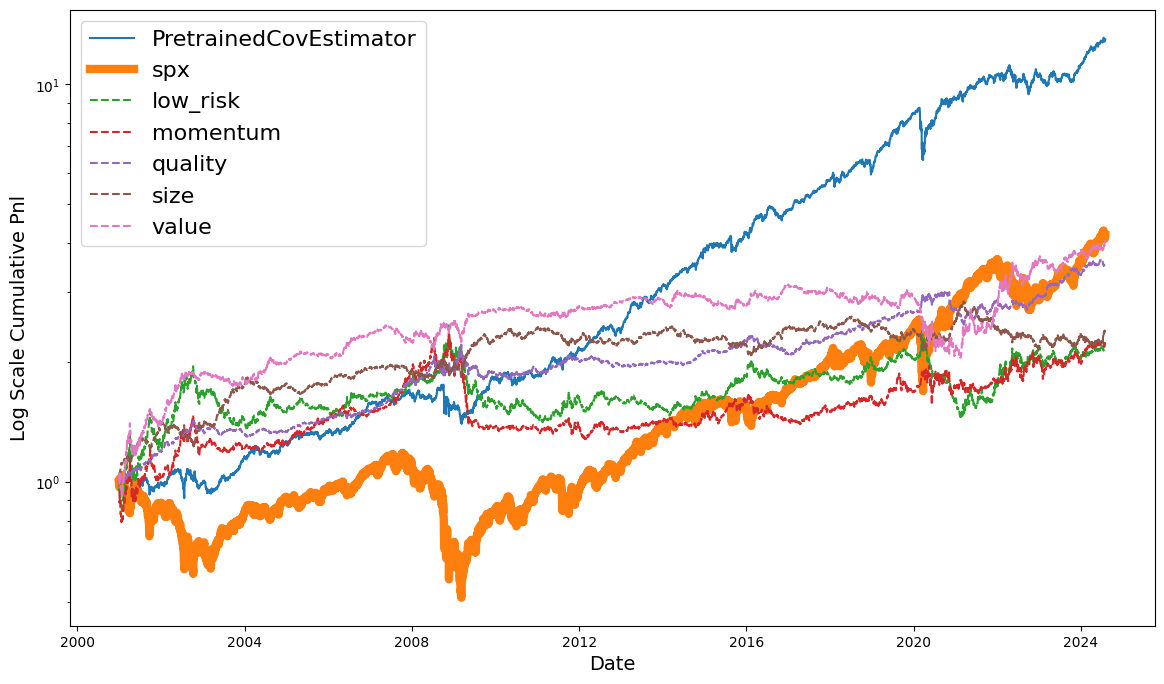

In [7]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

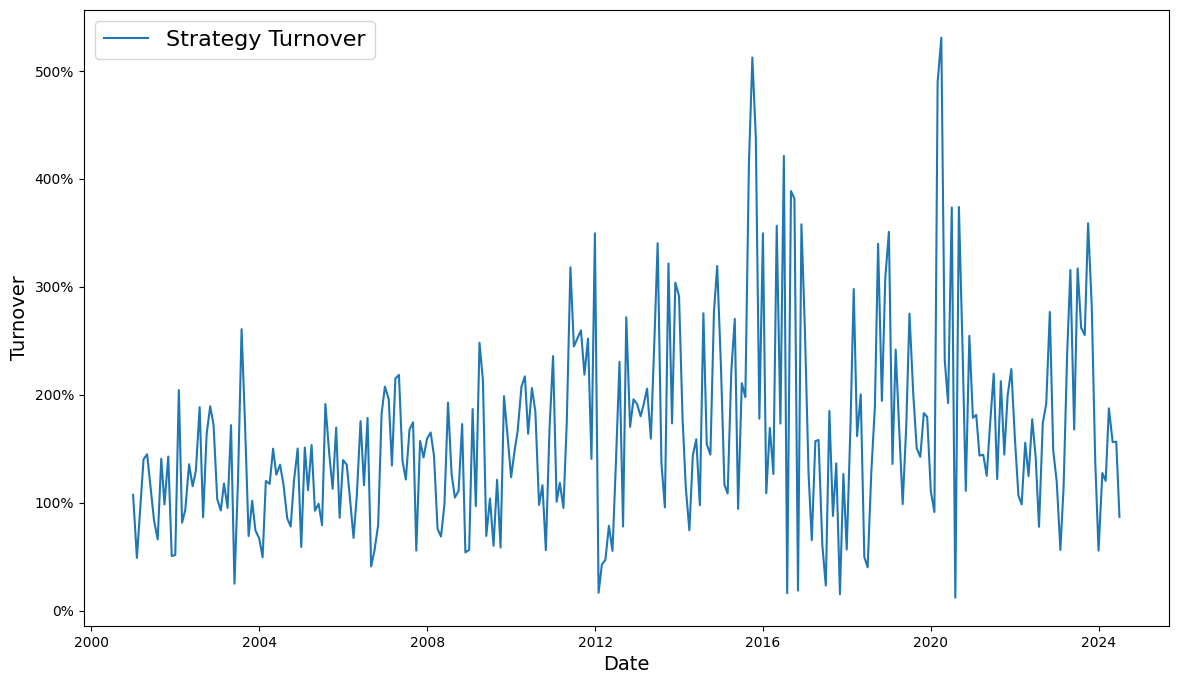

In [8]:
runner.plot_turnover()

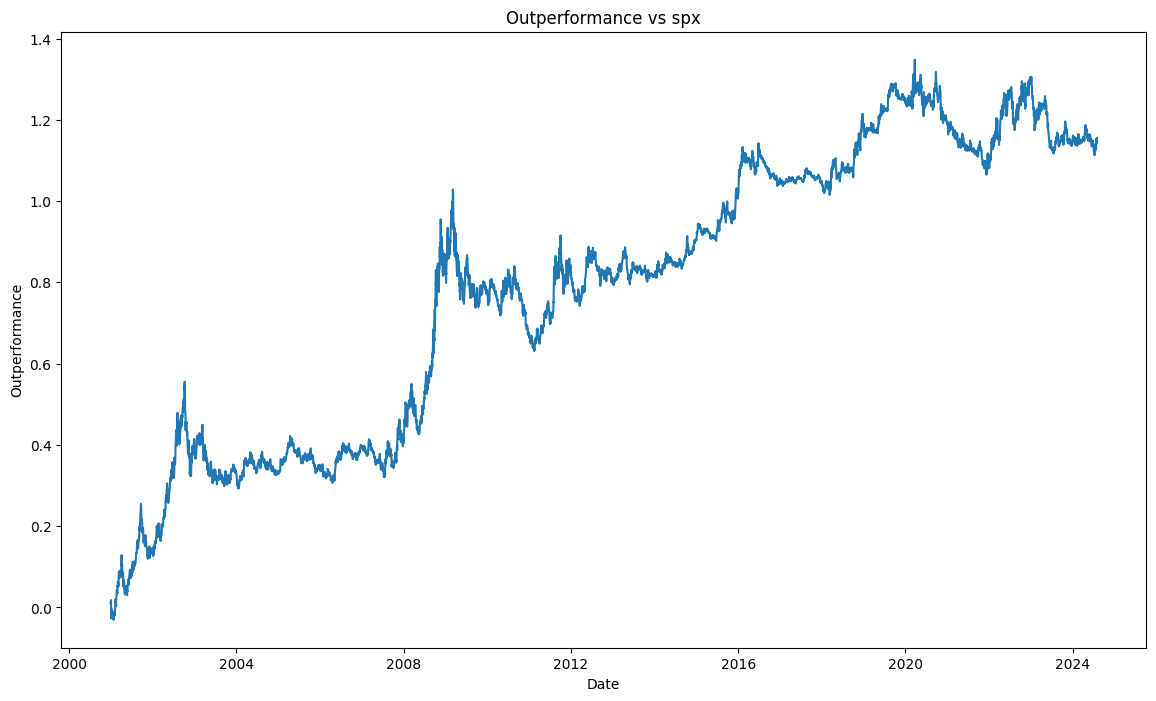

In [9]:
runner.plot_outperformance(mkt_only=True)

In [10]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

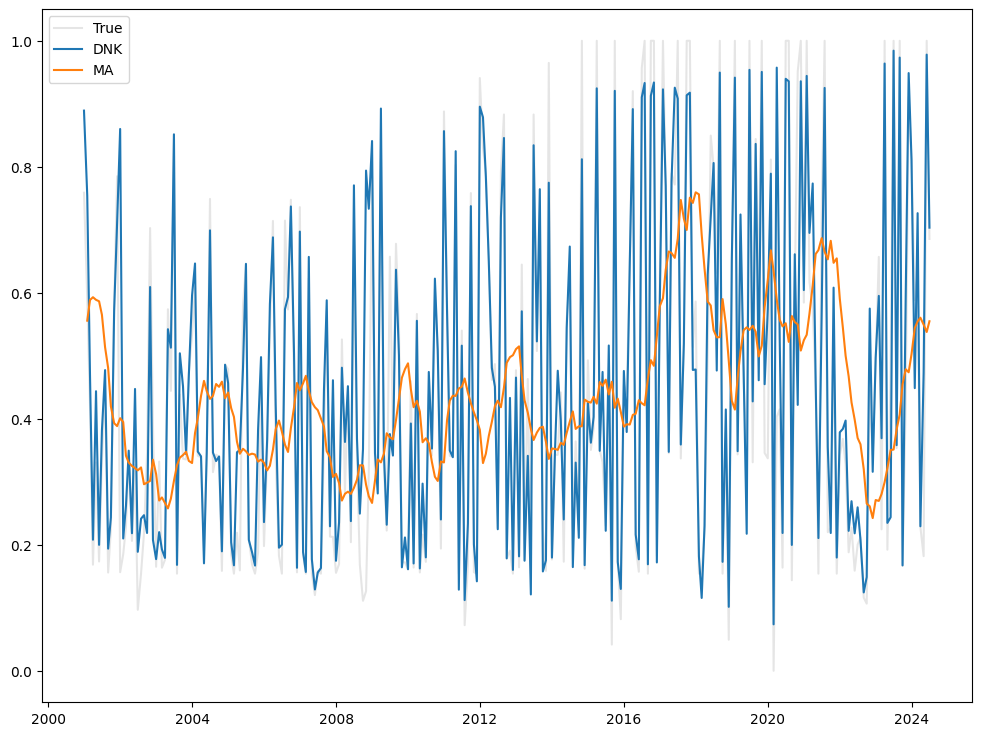

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label="DNK")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.06096717917182559

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

(targets.to_numpy() - pred.to_numpy()).mean(), mean_absolute_error(targets, pred), mean_squared_error(targets, pred)

(-0.015835728698028656, 0.06096717917182559, 0.011595770281027788)